In [8]:
import cv2
import numpy as np

from src.display import showarray
from src.feed import LiveFrameProcessor
from src.video import VideoHandler
from src.processing.analyzers import SimilarityAnalyzer, CardsAnalyzer, Analyzer
from src.processing.features import get_clear_edges

In [2]:
img = cv2.imread("data/images/rec_frame_c.jpg")

7 / 14 contours


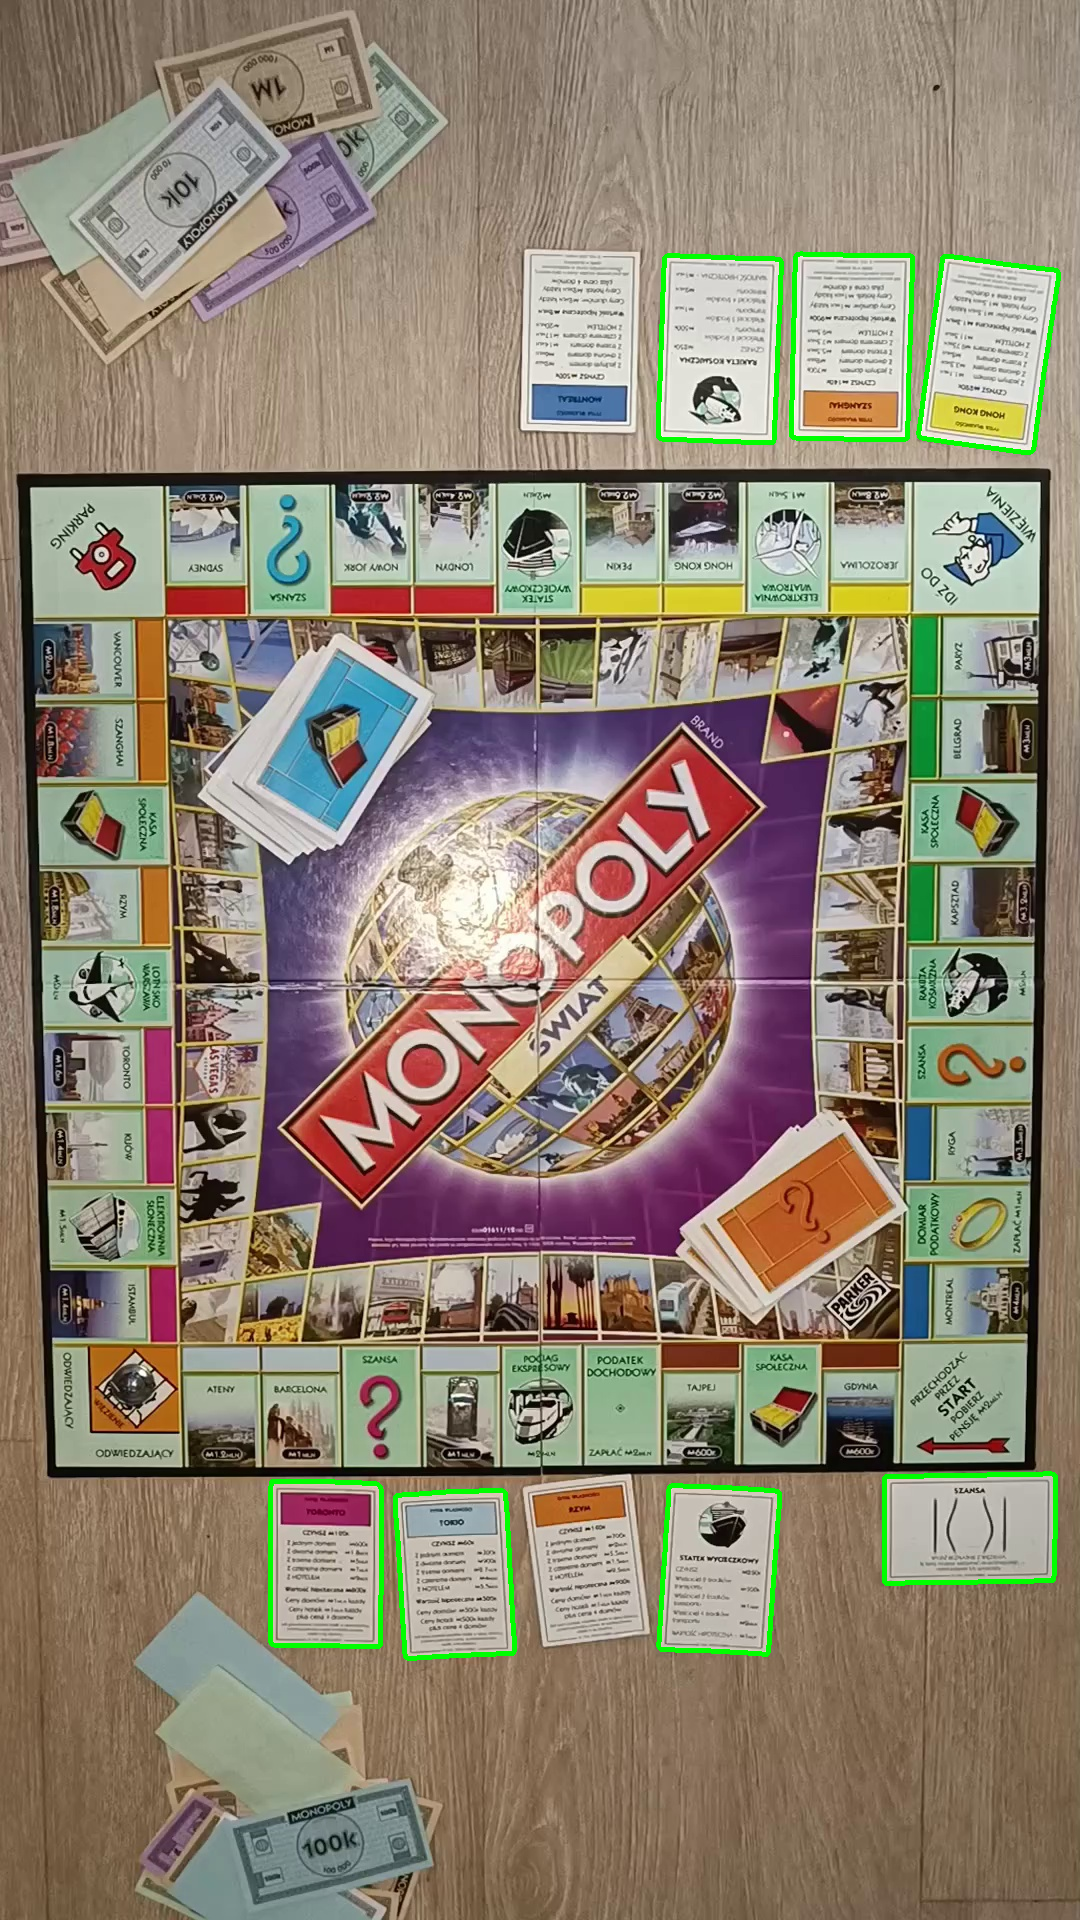

In [6]:
def is_min_area_rect_in_bounds(min_area_rect: tuple[tuple[float, float], tuple[float, float], float], area_low: int, area_high: int) -> bool:
    width = min_area_rect[1][0]
    height = min_area_rect[1][1]
    area =  width * height
    return area_low < area < area_high

def is_min_area_in_bounds_and_good_edges_ratio(contour: np.ndarray, area_low: int, area_high: int, ratio: float) -> bool:
    min_rect = cv2.minAreaRect(contour)
    width = min_rect[1][0]
    height = min_rect[1][1]
    actual_ratio = max(width, height) / min(width, height)
    return is_min_area_rect_in_bounds(min_rect, area_low, area_high) and abs(actual_ratio - ratio) < 0.1

CARD_RATIO = 8.5 / 5.5

def filter_contours(contours: list[np.ndarray]) -> list[np.ndarray]:
    return [
        contour 
        for contour in contours
        if cv2.contourArea(contour) > 600
        and is_min_area_in_bounds_and_good_edges_ratio(contour, 10_000, 25_000, CARD_RATIO)
    ]

edges = get_clear_edges(img)
contours, _ =cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = filter_contours(contours)
print(f"{len(filtered_contours)} / {len(contours)} contours")
img_with_contours = cv2.drawContours(img.copy(), filtered_contours, -1, (0, 255, 0), 3)
showarray(img_with_contours)

In [14]:
class EdgesAnalyzer(Analyzer):
    def analyze_raw(self, frame: np.ndarray, **kwargs) -> None:
        return

    def mutate_frame(self, frame: np.ndarray) -> np.ndarray:
        return get_clear_edges(frame)

    def get_context(self) -> dict:
        return {}

In [16]:
cards_analyzer = CardsAnalyzer(
    get_clear_edges,
    filter_contours,
    threaded=False,
)
# edges_analyzer = EdgesAnalyzer()
similarity_analyzer = SimilarityAnalyzer(threshold=0.9999, history_size=10)
processor = LiveFrameProcessor("feed", 800, 400)
with VideoHandler("data/recordings/Easy_2.mp4") as vh:
    vh.go_through_video(processor, [cards_analyzer, similarity_analyzer])